# Project fruit
The goal of this project is classifying fruits and determining its quality

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import datetime
import keras
import os
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [14]:
# Loads Tensorboard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
# Function to add monochromatic blocks randomly to the image
def add_monochromatic_blocks(image):
    height, width, channels = image.shape

    # Define the parameters for the blocks
    block_size = 10  # Size of each block in pixels
    num_blocks = 1  # Number of blocks to add

    # Generate random coordinates for the blocks
    block_coordinates = np.random.randint(0, min(height, width) - block_size, size=(num_blocks, 2))

    # Generate random colors for the blocks
    block_colors = np.random.randint(0, 256, size=(num_blocks, channels))

    # Apply the blocks to the image
    for coord, color in zip(block_coordinates, block_colors):
        x, y = coord
        image[x:x+block_size, y:y+block_size] = color

    return image

Specify paths, image dimensions, training configurations, and generate a descriptive model name.

In [16]:
# Specify the path for the datasets
dataset_dir = 'C:/Users/emanu/Documents/Programming/Python/Project/ADL/data'
train_path_360 = os.path.join(dataset_dir, 'fruits-360_mod/Training')
test_path_360 = os.path.join(dataset_dir, 'fruits-360_mod/Test')
train_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Train')
test_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Test')

# Specify image dimensions for the network
img_height, img_width, channels = 100, 100, 3

# Define the training configurations
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
SHEAR_RANGE = 0
ROTATION_RANGE = 180
ZOOM_RANGE = [1, 2]
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Choose transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='constant',
    cval=255,
    shear_range=SHEAR_RANGE,
    rotation_range=ROTATION_RANGE,
    zoom_range=ZOOM_RANGE,
    validation_split=0.2,
    # preprocessing_function=add_monochromatic_blocks
) # Add random cropping, horizontal flipping, or adjusting brightness/contrast?
test_datagen  = ImageDataGenerator(rescale = 1./255)

# Convert the learning rate and shear range to strings without the decimal point
learning_rate_str = str(LEARNING_RATE).replace(".", "")
shear_range_str = str(SHEAR_RANGE).replace(".", "")

# Generate a descriptive model name
model_name = f"fruit_model_lr{learning_rate_str}_bs{BATCH_SIZE}_sr{shear_range_str}_rr{ROTATION_RANGE}_zr{ZOOM_RANGE}.h5"
model_name

'fruit_model_lr00001_bs16_sr0_rr180_zr[1, 2].h5'

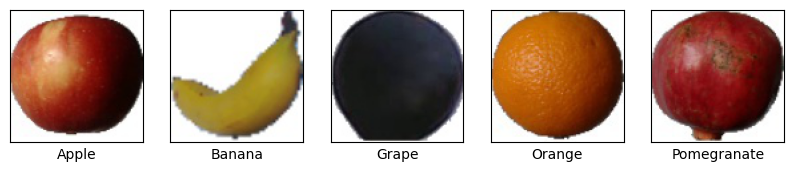

Size of image 1: (100, 100, 3)


In [17]:
# Insert fruits that you want to inspect
fruits = ['Apple', 'Banana', 'Grape', 'Orange', 'Pomegranate']
# Which image in the folder
fruitnr = 1

plt.figure(figsize=(10,10))
for i in range(len(fruits)):    
    img = load_img(train_path_360 + "/{fruit:}/{filename:}".format(fruit=fruits[i], filename=os.listdir(train_path_360 + '/' + fruits[i])[fruitnr-1]))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(fruits[i])
plt.show()

print("Size of image 1:".format(fruitnr=fruitnr), img_to_array(img).shape)

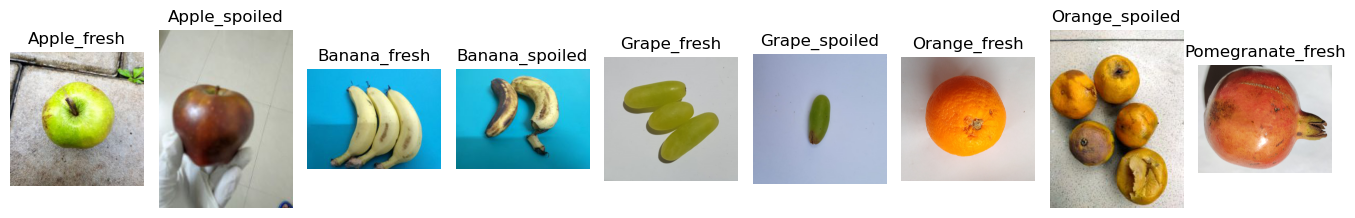

Size of image 1: (2509, 3084, 3)


In [18]:
# Insert fruits that you want to inspect
qfruits = ['Apple_fresh', 'Apple_spoiled', 'Banana_fresh', 'Banana_spoiled', 'Grape_fresh', 'Grape_spoiled', 'Orange_fresh', 'Orange_spoiled', 'Pomegranate_fresh', 'Pomegranate_spolied']
# Which image in the folder
fruitnr = 1

plt.figure(figsize=(15, 10))
num_fruits = len(qfruits)

for i, fruit in enumerate(qfruits):
    fruit_path = os.path.join(train_path_quality, fruit)
    
    # Cycle through all subdirectories and files in the fruit_path
    for root, dirs, files in os.walk(fruit_path):
        # Get the file path of the desired image
        img_path = os.path.join(root, files[fruitnr - 1])
        
        # Load the image
        img = load_img(img_path)
        
        # Create a subplot for the current fruit image
        plt.subplot(1, num_fruits, i+1)
        plt.imshow(img)
        plt.title(fruit)
        plt.axis('off')
        break  # Break after processing the first image

plt.tight_layout()
plt.show()

print("Size of image {fruitnr}:".format(fruitnr=fruitnr), img_to_array(img).shape)

Load VGG-16 and add FC layers

In [19]:
# Not pre-trained!
VGG16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(img_height,img_width,channels), weights=None)

# Get the list of subdirectories and count the number of subdirectories
subdirectories = [f.path for f in os.scandir(train_path_360) if f.is_dir()]
num_classes = len(subdirectories)

model = Sequential()

model.add(VGG16)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary(expand_nested=True, show_trainable=True)

Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)      [(None, 100, 100, 3)]     0         Y          |
|                                                                          |
| block1_conv1 (Conv2D)     (None, 100, 100, 64)      1792      Y          |
|                                                                          |
| block1_conv2 (Conv2D)     (None, 100, 100, 64)      36928     Y          |
|                                                                          |
| block1_pool (MaxPooling2D)  (None, 50, 50, 64)      0         Y          |
|                                                                          |
| block2_conv1 (Conv2D)     (None, 50, 50, 128)       

In [20]:
# Configures the model for training
model.compile(
    loss = "categorical_crossentropy",
    optimizer = OPTIMIZER,
    metrics = ["Accuracy", "Recall", "Precision"]
)

In [21]:
# Generates batches of augmented training and test data from directory
train_generator_360 = train_datagen.flow_from_directory(
    train_path_360,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "training")
validation_generator_360 = train_datagen.flow_from_directory(
    train_path_360,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "validation")
test_generator_360 = test_datagen.flow_from_directory(
    test_path_360,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical")

Found 8908 images belonging to 5 classes.
Found 2225 images belonging to 5 classes.
Found 3659 images belonging to 5 classes.


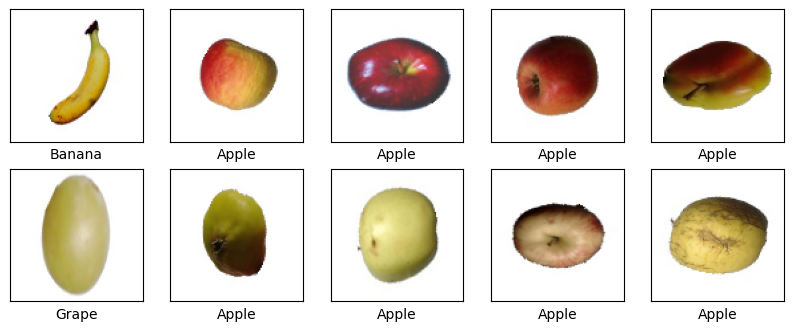

In [22]:
# Generate a batch of augmented images
augmented_images, labels = train_generator_360.next()

# Limit the number of images to display
num_images = min(augmented_images.shape[0], 10)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(augmented_images[i])
    plt.xlabel(fruits[np.argmax(labels[i] == 1)])
plt.show()

In [23]:
# # Reduces learning rate on performance plateau.
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', # It monitors the validation loss to determine whether to reduce the learning rate.
#     factor=0.1, # The learning rate is multiplied by this factor when triggered.
#     patience=3, # Number of epochs with no improvement after which the learning rate will be reduced.
#     min_lr=0.00001, # Lower bound on the learning rate.
#     verbose=1 # Controls the level of detail in output messages.
# )

# Create the "models" subdirectory if it doesn't exist
if not os.path.exists("360_models"):
    os.makedirs("360_models")

# Specify the path for saving the best model
model_path = os.path.join("360_models", model_name)

# Save the best model the model after every epoch
checkpointer_callback = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

# Stops training when monitored metric stops improving.
earlyStop_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_loss'
)

# TensorBoard logs for visualizing training progress.
log_dir = "logs/360/" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

callbacks = [
    checkpointer_callback,
    earlyStop_callback,
    tensorboard_callback,
    # reduce_lr_callback
]

In [24]:
# Train the model with specified settings and callbacks.
hist = model.fit(
    train_generator_360,
    epochs = 10,
    validation_data = validation_generator_360,
    callbacks=callbacks
)

Epoch 1/10
557/557 [==============================] - ETA: 0s - loss: 0.4310 - Accuracy: 0.8518 - recall: 0.8088 - precision: 0.8979
Epoch 1: val_loss improved from inf to 0.11125, saving model to 360_models\fruit_model_lr00001_bs16_sr0_rr180_zr[1, 2].h5
557/557 [==============================] - 528s 944ms/step - loss: 0.4310 - Accuracy: 0.8518 - recall: 0.8088 - precision: 0.8979 - val_loss: 0.1112 - val_Accuracy: 0.9497 - val_recall: 0.9411 - val_precision: 0.9540
Epoch 2/10
557/557 [==============================] - ETA: 0s - loss: 0.1106 - Accuracy: 0.9694 - recall: 0.9646 - precision: 0.9746
Epoch 2: val_loss did not improve from 0.11125
557/557 [==============================] - 507s 911ms/step - loss: 0.1106 - Accuracy: 0.9694 - recall: 0.9646 - precision: 0.9746 - val_loss: 0.1804 - val_Accuracy: 0.9384 - val_recall: 0.9362 - val_precision: 0.9455
Epoch 3/10
557/557 [==============================] - ETA: 0s - loss: 0.0841 - Accuracy: 0.9764 - recall: 0.9716 - precision: 0.980

Load the best model, evaluate it on the test data, and save the evaluation results with additional information to a file.

In [25]:
# Load the best model
best_model = load_model(os.path.join('360_models', model_name))

# Evaluate the model
test_acc = best_model.evaluate(test_generator_360, verbose=2)

# Get the evaluation results with 4 decimal places
loss = round(test_acc[0], 4)
accuracy = round(test_acc[1], 4)
recall = round(test_acc[2], 4)
precision = round(test_acc[3], 4)

# Write the results to a string
result_string = f"Loss={loss:.4f}, Accuracy={accuracy:.4f}, Recall={recall:.4f}, Precision={precision:.4f}"

# Get the optimizer, learning rate, batch size, and transformations used
optimizer_name = best_model.optimizer.__class__.__name__
transformations = {
    key: value
    if key != 'rescale' else f"{1/value:.4f}"
    for key, value in train_datagen.__dict__.items()
    if key in ['rescale', 'fill_mode', 'cval', 'shear_range', 'rotation_range', 'zoom_range', 'validation_split']
    and value is not None and value != 0 and not callable(value)
}

# Write the additional information to a string
additional_info = (
    f"Optimizer={optimizer_name}, Learning Rate={LEARNING_RATE:.4f}, Batch Size={BATCH_SIZE},"
    f" Transformations={transformations}"
)

# Check if the file exists
if os.path.exists("model_acc.txt"):
    # If the file exists, open it in append mode
    with open("model_acc.txt", "a") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")
else:
    # If the file does not exist, create it and write the results
    with open("model_acc.txt", "w") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")

229/229 - 61s - loss: 0.0276 - Accuracy: 0.9918 - recall: 0.9910 - precision: 0.9918 - 61s/epoch - 266ms/step


In [26]:
# Launces application 'Tensorboard' that compiles all data from code-run in file path 'logs'
%tensorboard --logdir logs --port=6006 # 8008